## K-Nearest Neighbors (kNN)

As always, let's begin by importing our handy dandy pandas package. Today, we'll also be using numpy.

In [72]:
import pandas as pd
import numpy as np

### Some Simple Data Cleaning

The **Wisconsin Breast Cancer Dataset** is a collection of medical data used to study breast cancer characteristics. It was gathered from fine needle aspirate (FNA) biopsies, a procedure where a thin needle extracts cell samples from a breast lump for examination. The dataset was compiled by Dr. William H. Wolberg at the University of Wisconsin to aid in understanding differences between benign (non-cancerous) and malignant (cancerous) tumors.

What the Data Contains:
- **30 measured attributes** describing cell nuclei, such as:
- **Size** (e.g., radius, perimeter, and area)
- **Shape** (e.g., compactness, concavity, symmetry)
- **Texture** (e.g., smoothness, fractal dimension)

Each sample is classified as either benign or malignant based on these measurements.
The dataset includes 569 cases from real patient data.

This data has been widely used in medical research to understand the distinguishing features of different types of breast tumors and improve diagnostic methods. Today, we'll be using this data to try to predict whether a tumor is benign or malignant using a K-Nearest Neighbors classification model (kNN classification).

In [73]:
df = pd.read_csv('breast-cancer-wisconsin.csv')
print(df.shape)
df.iloc[:5]

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


For the sake of simplicity, we're only going to work with the first few columns - only the means for each of the categories. We're excluding things like the standard deviation, minimum, and maximum of these measurements.

In [74]:
df = df.drop(columns = df.columns[12:])
print(df.shape)
df.iloc[:5]

(569, 12)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


I notice one problem with this dataset so far. We're trying to predict the `diagnosis` column of the data set.

Currently, this column contains values of `M` for **malignant** (aka cancer) or `B` for **benign** (aka no cancer).

However, a kNN Model will have no idea what `M` or `B` means. It wants to predict a number. So we have to convert this column from M's and B's into 1s and 0s so the model will actually know how to make predictions. We'll use the `apply` method and a lambda function to reassign the values in the diagnosis column to 1 for malignant (positive case) and 0 for benign (negative case).

In [75]:
df['diagnosis'] = df['diagnosis'].apply(lambda x: 1 if x == "M" else 0 if x == "B" else np.nan())
df['diagnosis'].value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

We have slightly more cases of benign masses than malignant masses (just over 60%).

Let's take a slightly closer look at our data set before moving on with building a model:

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      569 non-null    int64  
 1   diagnosis               569 non-null    int64  
 2   radius_mean             569 non-null    float64
 3   texture_mean            569 non-null    float64
 4   perimeter_mean          569 non-null    float64
 5   area_mean               569 non-null    float64
 6   smoothness_mean         569 non-null    float64
 7   compactness_mean        569 non-null    float64
 8   concavity_mean          569 non-null    float64
 9   concave points_mean     569 non-null    float64
 10  symmetry_mean           569 non-null    float64
 11  fractal_dimension_mean  569 non-null    float64
dtypes: float64(10), int64(2)
memory usage: 53.5 KB


Perfect! We have no null values in any of our columns and all of our columns have the proper data type! We're ready to move onto modeling.

### Modeling with kNN

First, we need to import all of the packages that we will use for building and analyzing our model.

In [77]:
from sklearn.model_selection import train_test_split # to create training and testing data
from sklearn.preprocessing import StandardScaler # for scaling data
from sklearn.neighbors import KNeighborsClassifier # to build kNN model
from sklearn.metrics import roc_auc_score # to evaluate model using ROC AUC
import matplotlib.pyplot as plt # for data visualization purposes

#### Train-Test Split

Our first step in this process is splitting our data. Remember that a train-test split is crucial in data analysis because it helps evaluate how well a model generalizes to new, unseen data. By splitting the dataset into a training set (used to train the model) and a test set (used to assess performance), we can detect overfitting, where a model performs well on training data but poorly on new data.

In [78]:
X = df.drop(columns = df.columns[0:2])
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 412)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(398, 10)
(171, 10)
(398,)
(171,)


We need to set aside the column names, we'll use them in a second.

In [79]:
cols = X_train.columns

#### Scaling the Data

Scaling the data is crucial for a k-Nearest Neighbors (kNN) model because kNN relies on distance metrics (e.g., Euclidean distance) to classify points. If the features have different scales (e.g., height in centimeters vs. weight in kilograms), larger values can dominate the distance calculations, leading to biased results. Standardizing or normalizing the data ensures that all features contribute equally to the distance computation, improving the model's accuracy and reliability.

We'll use the standard scaler, which puts values into a standard normal distribution with mean 0 and standard deviation 1. There are other ways to scale the data, such as a min-max scaler which places all values between 0 and 1, but for today we'll use the standard scaler.

In [80]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [81]:
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

X_train.iloc[:5]

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,-1.383970,-1.301519,-1.330468,-1.125278,2.872850,0.310738,-0.709434,-0.662991,1.373738,2.147180
1,-0.587902,-0.308132,-0.592087,-0.585630,-0.419948,-0.508591,-0.760229,-0.888401,-1.302925,0.020732
2,-0.118320,-0.993641,-0.161062,-0.224682,-0.114386,-0.536447,-0.569381,-0.337734,1.056044,-0.628347
3,-0.793518,0.257113,-0.620687,-0.774712,3.257473,3.308011,1.831301,1.379068,2.834401,5.231434
4,-0.582345,0.290787,-0.635189,-0.576340,-1.184920,-1.214269,-0.825311,-0.827132,-0.298720,-0.893400


#### Fitting the kNN Model

In [82]:
knn = KNeighborsClassifier(n_neighbors=5) # initialize kNN model
knn.fit(X_train, y_train) # train the kNN model

KNeighborsClassifier()

#### Making Predictions Using Our kNN Model

Now we can do the fun part! Let's make some predictions and see how we do.

First, let's make some predictions of the class (a simple 0 or 1)

In [83]:
y_pred = knn.predict(X_test)
y_pred

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0])

We can also use the predicted probabilities (between 0 and 1) instead of just the 0 or 1. In fact, these probabilities will be necessary if we're evaluating our model using a more advanced metric such as ROC AUC or Log Loss (which we'll do here in a second).

**Do you notice anything interesting about these predicted probabilities?**

In [84]:
y_pred_probs = knn.predict_proba(X_test)[:,1]
y_pred_probs

array([0. , 0.6, 1. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0.2, 0. , 1. ,
       0. , 0. , 0. , 0. , 0. , 1. , 0. , 1. , 1. , 0. , 0. , 0.6, 0. ,
       0. , 1. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0.2, 0. , 0.6, 1. , 1. , 0.2, 1. , 0. , 0.2,
       0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0.8, 1. , 1. ,
       1. , 0. , 1. , 0.6, 0.4, 1. , 0. , 1. , 1. , 0. , 0. , 0.8, 0. ,
       0. , 1. , 0. , 0. , 1. , 1. , 0.2, 0. , 0. , 1. , 0. , 1. , 0. ,
       0. , 0.8, 0. , 0. , 0. , 0.2, 0. , 1. , 1. , 0. , 0. , 0. , 0.2,
       0. , 1. , 0. , 1. , 0. , 0.2, 1. , 0. , 0.4, 0. , 0.4, 0. , 0.2,
       1. , 0. , 0. , 0. , 0.2, 0. , 0. , 1. , 1. , 0. , 0. , 0. , 0.8,
       0.2, 0. , 0.6, 1. , 0. , 1. , 0. , 1. , 0.4, 0. , 1. , 0. , 0.6,
       0. , 0. , 0. , 0. , 0.6, 1. , 0.4, 0. , 0. , 0. , 0.2, 0. , 1. ,
       1. , 0.8, 0.8, 1. , 1. , 1. , 1. , 1. , 0. , 0.2, 0. , 1. , 0.2,
       0.2, 0. ])

Now we can compare these predicted probabilities to the actual y values to calculate ROC AUC:

In [85]:
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.9906


Wow! This model did very, very well since ROC AUC is very close to 1. Even with a fairly simple model and without very much data, we can do really well with these predictions. Turns out predicting whether a breast mass is cancerous is not very difficult if you have the right data collection methods. Let's see if you can do even better...

### **Competition Time!**

Try a few different values for k and let's see who can get the highest value for ROC AUC!

In [86]:
# Answer here:


Highlight the complete code chunk below, then you can use `CTRL` + `/` to uncomment the entire code block:

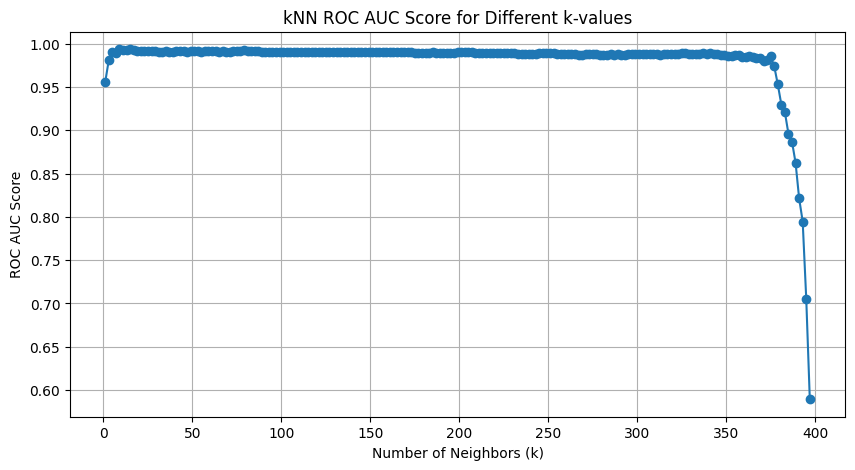

In [88]:
k_values = range(1, 399, 2)  # only odd values to avoid ties in classification
auc_scores = []

# loop over k values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # predict probabilities for the positive class
    y_prob = knn.predict_proba(X_test)[:, 1]  # probabilities for class 1
    
    # compute AUC
    auc = roc_auc_score(y_test, y_prob)
    auc_scores.append(auc)

# plot ROC AUC vs. k
plt.figure(figsize=(10, 5))
plt.plot(k_values, auc_scores, marker='o', linestyle='-')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('ROC AUC Score')
plt.title('kNN ROC AUC Score for Different k-values')
plt.grid(True)
plt.show()

In [91]:
auc_scores

[np.float64(0.956055900621118),
 np.float64(0.9813664596273293),
 np.float64(0.9906055900621118),
 np.float64(0.9894409937888199),
 np.float64(0.9937111801242237),
 np.float64(0.9926242236024845),
 np.float64(0.9927018633540372),
 np.float64(0.9934006211180124),
 np.float64(0.9925465838509316),
 np.float64(0.9915372670807453),
 np.float64(0.9919254658385093),
 np.float64(0.9914596273291926),
 np.float64(0.9914596273291926),
 np.float64(0.9921583850931677),
 np.float64(0.9917701863354037),
 np.float64(0.9906832298136645),
 np.float64(0.9910714285714285),
 np.float64(0.9911490683229814),
 np.float64(0.9909937888198758),
 np.float64(0.9906832298136646),
 np.float64(0.991304347826087),
 np.float64(0.9918478260869565),
 np.float64(0.9916925465838509),
 np.float64(0.9910714285714286),
 np.float64(0.9911490683229814),
 np.float64(0.9912267080745341),
 np.float64(0.991692546583851),
 np.float64(0.9909937888198759),
 np.float64(0.991692546583851),
 np.float64(0.9916925465838509),
 np.float64(0.

In [90]:
max(auc_scores)

np.float64(0.9937111801242237)

Some final words on when to use kNN to make predictions:

k-Nearest Neighbors (kNN) classifiers are most useful when:

**The decision boundary is non-linear** – kNN can capture complex, non-linear decision boundaries better than linear models.

**You have a small to moderate amount of data** – kNN performs well on small to moderately sized datasets but becomes inefficient with very large datasets due to its computational cost.

**Feature scaling is handled properly** – Since kNN relies on distance metrics (e.g., Euclidean), features should be normalized to avoid dominance by larger-scale features.

**There is a natural clustering in the data** – kNN works well when similar data points belong to the same class, making it useful in cases like image recognition and recommendation systems.

**Interpretability is important** – Unlike more complex models, kNN is intuitive and easy to explain.

However, kNN is less suitable for high-dimensional data (due to the curse of dimensionality) or when real-time predictions are required, as it can be slow at inference time.